# Spike Gadgets Ephys and Video Syncing

In [1]:
import os
import re
import sys
from collections import defaultdict
import random
from random import randrange
import glob
import warnings

In [2]:
import numpy as np
import pandas as pd
# import cv2
from IPython.display import Video
import matplotlib.pyplot as plt

In [3]:
# setting path
sys.path.append('../../../src')

In [4]:
import trodes.read_exported

In [5]:
%matplotlib inline

In [6]:
import spikeinterface

In [7]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

/tmp/ipykernel_557844/634830499.py:3: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


In [8]:
import spikeinterface.core

In [9]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

In [10]:
import spikeinterface.full as si

# Reading in the Timestamp Information

In [11]:
tone_time_stamps_df = pd.read_csv("./proc/subj_6_1_date_20221214_tone_label_df.csv", index_col=0)

In [12]:
tone_time_stamps_df

,tone_time_stamp,tone_category
0,1408048,rewarded
1,3008051,rewarded
2,4808043,rewarded
3,6408042,omission
4,7908040,rewarded
5,9908037,rewarded
6,11808035,rewarded
7,13608031,rewarded
8,15208032,omission
9,17008029,rewarded


# Reading in Phy

- Which unit the spike came from

In [13]:
spike_clusters = np.load("./proc/subject_6_1_omission_and_competition_with_6_3/mountainsort4/2022_12_21/phy/spike_clusters.npy")

In [14]:
spike_clusters[:10]

array([ 39, 170,  60,  60,  88, 183,  19,  67, 174,  20], dtype=int32)

- The classification of each unit

In [15]:
cluster_group_df = pd.read_csv("./proc/subject_6_1_omission_and_competition_with_6_3/mountainsort4/2022_12_21/phy/cluster_info.tsv", sep="\t")

In [16]:
non_mpfc_channels = [13, 14, 15, 31]

In [17]:
cluster_group_df = cluster_group_df[~cluster_group_df["ch"].isin(non_mpfc_channels)]

In [18]:
cluster_group_df

,cluster_id,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
0,0,427.0,0,0.0,0.0,0.263283,noise,844,0,1.0
1,2,188.0,1,0.0,20.0,1.147027,mua,3677,0,3.0
2,3,193.0,1,0.0,20.0,0.859724,noise,2756,0,4.0
3,4,871.0,2,0.0,40.0,12.211762,mua,39147,0,5.0
4,5,504.0,2,0.0,40.0,3.960782,mua,12697,0,6.0
...,...,...,...,...,...,...,...,...,...,...
93,183,932.0,29,0.0,580.0,9.470066,good,30358,0,73.0
94,187,568.0,6,0.0,120.0,0.096079,mua,308,0,19.0
95,188,568.0,6,0.0,120.0,0.664446,good,2130,0,19.0
96,197,932.0,29,0.0,580.0,0.351563,mua,1127,0,73.0


- Filtering for the good units

In [19]:
good_unit_cluster_info_df = cluster_group_df[cluster_group_df["group"] == "good"]

In [20]:
good_unit_cluster_info_df

,cluster_id,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
15,16,1147.5,6,0.0,120.0,0.864403,good,2771,0,17.0
18,20,1113.0,7,0.0,140.0,5.995296,good,19219,0,21.0
22,24,1206.0,9,0.0,180.0,5.371091,good,17218,0,25.0
35,50,1644.0,21,0.0,420.0,1.107409,good,3550,0,51.0
36,52,870.0,21,0.0,420.0,1.168551,good,3746,0,53.0
38,54,448.5,22,0.0,440.0,7.901600,good,25330,0,55.0
43,59,253.0,24,0.0,480.0,1.836116,good,5886,0,60.0
47,64,633.0,26,0.0,520.0,2.901412,good,9301,0,65.0
81,156,440.0,19,0.0,380.0,0.868770,good,2785,0,47.0
84,163,542.0,21,0.0,420.0,1.598101,good,5123,0,52.0


In [21]:
good_unit_unique_ids = good_unit_cluster_info_df["cluster_id"].values

In [22]:
good_unit_unique_ids

array([ 16,  20,  24,  50,  52,  54,  59,  64, 156, 163, 174, 182, 183,
       188])

- The times that all the spikes happened

In [23]:
spike_times = np.load("./proc/subject_6_1_omission_and_competition_with_6_3/mountainsort4/2022_12_21/phy/spike_times.npy")

In [24]:
spike_times[:10]

array([[ 11],
       [ 89],
       [143],
       [178],
       [215],
       [260],
       [309],
       [344],
       [413],
       [487]])

- Getting a list of the IDs that were good from the list of unit ids for all the firings

In [25]:
good_unit_mask = np.isin(spike_clusters, good_unit_unique_ids)

In [26]:
good_unit_all_ids = spike_clusters[good_unit_mask]

In [27]:
good_unit_all_ids.shape

(172619,)

In [28]:
good_unit_all_ids[:10]

array([183, 174,  20, 183,  24, 182, 183,  54,  54,  64], dtype=int32)

- Getting the time that the good units fired

In [29]:
good_unit_times = spike_times[good_unit_mask].T[0]

In [30]:
good_unit_times.shape

(172619,)

In [31]:
good_unit_times[:10]

array([ 260,  413,  487,  821, 1190, 1588, 1640, 1701, 2087, 2467])

In [32]:
good_unit_times[-10:]

array([64108851, 64109062, 64109114, 64109909, 64110757, 64110943,
       64111416, 64112221, 64112277, 64113530])

- spike_times are indexed based on the start of the recording, not the start of the streaming
    - Last spike ends right before the end of the recording time

In [33]:
spike_times

array([[      11],
       [      89],
       [     143],
       ...,
       [64113456],
       [64113530],
       [64113594]])

In [34]:
spike_times[-1]/20000

array([3205.6797])

## Syncing the unit times with the ECU times

In [35]:
tone_time_stamps = tone_time_stamps_df["tone_time_stamp"].values

In [36]:
tone_time_stamps

array([ 1408048,  3008051,  4808043,  6408042,  7908040,  9908037,
       11808035, 13608031, 15208032, 17008029, 19008027, 20808026,
       23208023, 25008021, 27998597, 29598593, 31398591, 32998593,
       34498591, 36498588, 38398586, 40198584, 41798580, 43598581,
       45598579, 47398577, 49798572, 51598570, 53298568, 55098566,
       56998564, 59398564, 60998563])

## Seeing which tone time each unit time is closest to

- We will divide all the time up into bins of before and after each tone. Then we will see which time bin the neuron firing falls into.
    - So everything in the 0 bin would be before the first time bin. The 1 bin would be everything in between the first and second time bin. The last would be everything after last time bin.

In [37]:
good_unit_bins = np.digitize(good_unit_times, tone_time_stamps_df["tone_time_stamp"], right=True)

In [38]:
good_unit_bins.shape

(172619,)

In [39]:
good_unit_bins[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [40]:
good_unit_bins[-10:]

array([33, 33, 33, 33, 33, 33, 33, 33, 33, 33])

- Seeing if the firing time is within a 10 second interval before or 10 second after any tone

In [41]:
from collections import defaultdict

In [42]:
good_unit_bins.shape

(172619,)

In [43]:
good_unit_times.shape

(172619,)

In [44]:
good_unit_all_ids.shape

(172619,)

In [45]:
good_unit_times[:10]

array([ 260,  413,  487,  821, 1190, 1588, 1640, 1701, 2087, 2467])

In [46]:
tone_time_stamps

array([ 1408048,  3008051,  4808043,  6408042,  7908040,  9908037,
       11808035, 13608031, 15208032, 17008029, 19008027, 20808026,
       23208023, 25008021, 27998597, 29598593, 31398591, 32998593,
       34498591, 36498588, 38398586, 40198584, 41798580, 43598581,
       45598579, 47398577, 49798572, 51598570, 53298568, 55098566,
       56998564, 59398564, 60998563])

In [47]:
len(tone_time_stamps)

33

In [48]:
# time in seconds
trial_one_way_duration = 10

In [49]:
sampling_rate = 20000

# Comparing Firing Rate between Trial types

In [50]:
tone_time_stamps_df.head()

,tone_time_stamp,tone_category
0,1408048,rewarded
1,3008051,rewarded
2,4808043,rewarded
3,6408042,omission
4,7908040,rewarded


In [51]:
good_unit_times

array([     260,      413,      487, ..., 64112221, 64112277, 64113530])

In [52]:
good_unit_all_ids

array([183, 174,  20, ..., 183, 174,  54], dtype=int32)

In [53]:
good_unit_bins

array([ 0,  0,  0, ..., 33, 33, 33])

In [54]:
tone_time_stamps

array([ 1408048,  3008051,  4808043,  6408042,  7908040,  9908037,
       11808035, 13608031, 15208032, 17008029, 19008027, 20808026,
       23208023, 25008021, 27998597, 29598593, 31398591, 32998593,
       34498591, 36498588, 38398586, 40198584, 41798580, 43598581,
       45598579, 47398577, 49798572, 51598570, 53298568, 55098566,
       56998564, 59398564, 60998563])

In [55]:
"""
Step 1: 
- Get all the unit times that are 10 seconds before tone 
and 10 seconds after the tone(separately)

Step 2:
- Separate out for each trial

Step 3: Calculate firing rate
"""

'\nStep 1: \n- Get all the unit times that are 10 seconds before tone \nand 10 seconds after the tone(separately)\n\nStep 2:\n- Separate out for each trial\n\nStep 3: Calculate firing rate\n'

In [56]:
# iterating through the timestamp of each good unit spike

before_and_after_interval_unit_times = defaultdict(dict)

per_trial_number_of_samples = trial_one_way_duration * sampling_rate

for index, time in enumerate(good_unit_times):
    # getting the corresponding tone bin for the timestamp
    current_bin = good_unit_bins[index]
    current_neuron = good_unit_all_ids[index]   
    
    # checking number before
    first_tone_time = tone_time_stamps[(current_bin - 1) % len(tone_time_stamps)]
    # checking number after
    second_tone_time = tone_time_stamps[(current_bin) % len(tone_time_stamps)]    
    
    # checking if time is before first number
    if first_tone_time - per_trial_number_of_samples <= time <= first_tone_time:
        before_and_after_interval_unit_times[time]["tone_time"] = first_tone_time
        before_and_after_interval_unit_times[time]["before_or_after"] = "before"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    # checking if time is after first number
    elif first_tone_time < time <= first_tone_time + per_trial_number_of_samples:
        before_and_after_interval_unit_times[time]["tone_time"] = first_tone_time
        before_and_after_interval_unit_times[time]["before_or_after"] = "after"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    # checking if time is before second number
    if second_tone_time - per_trial_number_of_samples <= time <= second_tone_time:
        before_and_after_interval_unit_times[time]["tone_time"] = second_tone_time
        before_and_after_interval_unit_times[time]["before_or_after"] = "before"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    # checking if time is after second number
    elif second_tone_time < time <= second_tone_time + per_trial_number_of_samples:
        before_and_after_interval_unit_times[time]["tone_time"] = second_tone_time
        before_and_after_interval_unit_times[time]["before_or_after"] = "after"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]

In [57]:
per_trial_number_of_samples

200000

In [58]:
before_and_after_interval_unit_df = pd.DataFrame.from_dict(before_and_after_interval_unit_times, orient="index").reset_index()
before_and_after_interval_unit_df = before_and_after_interval_unit_df.rename(columns={"index": "spike_time"})

In [59]:
before_and_after_interval_unit_df.head()

,spike_time,tone_time,before_or_after,neuron_id
0,1209073,1408048,before,64
1,1210306,1408048,before,54
2,1210810,1408048,before,174
3,1211041,1408048,before,52
4,1212118,1408048,before,54


In [60]:
before_and_after_tone_spike_count_df = before_and_after_interval_unit_df.groupby(["tone_time", "before_or_after", "neuron_id"]).count().unstack(fill_value=0).stack().reset_index().rename(columns={"spike_time": "fired_spike_count"})

In [61]:
before_tone_spike_count_df = before_and_after_tone_spike_count_df[before_and_after_tone_spike_count_df["before_or_after"] == "before"].rename(columns={"fired_spike_count": "before_fired_spike_count"})
after_tone_spike_count_df = before_and_after_tone_spike_count_df[before_and_after_tone_spike_count_df["before_or_after"] == "after"].rename(columns={"fired_spike_count": "after_fired_spike_count"})

In [62]:
before_tone_spike_count_df.head()

,tone_time,before_or_after,neuron_id,before_fired_spike_count
14,1408048,before,16,7
15,1408048,before,20,92
16,1408048,before,24,59
17,1408048,before,50,3
18,1408048,before,52,8


In [63]:
after_tone_spike_count_df.head()

,tone_time,before_or_after,neuron_id,after_fired_spike_count
0,1408048,after,16,6
1,1408048,after,20,157
2,1408048,after,24,53
3,1408048,after,50,2
4,1408048,after,52,12


In [64]:
merged_before_after_tone_spike_count_df = pd.merge(left=before_tone_spike_count_df, right=after_tone_spike_count_df, left_on=["tone_time", "neuron_id"], right_on=["tone_time", "neuron_id"])

- Adding the trial type

In [65]:
tone_timestamp_to_trial_type = pd.Series(tone_time_stamps_df["tone_category"].values, index=tone_time_stamps_df["tone_time_stamp"]).to_dict()

In [66]:
tone_timestamp_to_trial_type

{1408048: 'rewarded',
 3008051: 'rewarded',
 4808043: 'rewarded',
 6408042: 'omission',
 7908040: 'rewarded',
 9908037: 'rewarded',
 11808035: 'rewarded',
 13608031: 'rewarded',
 15208032: 'omission',
 17008029: 'rewarded',
 19008027: 'rewarded',
 20808026: 'omission',
 23208023: 'rewarded',
 25008021: 'rewarded',
 27998597: 'loss',
 29598593: 'win',
 31398591: 'win',
 32998593: 'win',
 34498591: 'win',
 36498588: 'win',
 38398586: 'win',
 40198584: 'win',
 41798580: 'win',
 43598581: 'win',
 45598579: 'win',
 47398577: 'win',
 49798572: 'loss',
 51598570: 'loss',
 53298568: 'loss',
 55098566: 'loss',
 56998564: 'win',
 59398564: 'loss',
 60998563: 'loss'}

In [67]:
merged_before_after_tone_spike_count_df["trial_type"] = merged_before_after_tone_spike_count_df["tone_time"].map(tone_timestamp_to_trial_type)

In [68]:
merged_before_after_tone_spike_count_df

,tone_time,before_or_after_x,neuron_id,before_fired_spike_count,before_or_after_y,after_fired_spike_count,trial_type
0,1408048,before,16,7,after,6,rewarded
1,1408048,before,20,92,after,157,rewarded
2,1408048,before,24,59,after,53,rewarded
3,1408048,before,50,3,after,2,rewarded
4,1408048,before,52,8,after,12,rewarded
...,...,...,...,...,...,...,...
457,60998563,before,163,17,after,4,loss
458,60998563,before,174,80,after,63,loss
459,60998563,before,182,6,after,4,loss
460,60998563,before,183,140,after,135,loss


- Calculating Wilcoxon

In [69]:
import scipy.stats as stats

In [70]:
import itertools

In [71]:
merged_before_after_tone_spike_count_df["neuron_id"].unique()

merged_before_after_tone_spike_count_df["trial_type"].unique()


array(['rewarded', 'omission', 'loss', 'win'], dtype=object)

In [72]:
neuron_id_to_trial_type_to_wilcoxon_score = defaultdict(dict)
neuron_id_and_trial_type_combinations = list(itertools.product(merged_before_after_tone_spike_count_df["neuron_id"].unique(), merged_before_after_tone_spike_count_df["trial_type"].unique()))
for neuron_id, trial_type in neuron_id_and_trial_type_combinations:
    current_df = merged_before_after_tone_spike_count_df[(merged_before_after_tone_spike_count_df["neuron_id"] == neuron_id) & (merged_before_after_tone_spike_count_df["trial_type"] == trial_type)]
    neuron_id_to_trial_type_to_wilcoxon_score[neuron_id][trial_type] = stats.wilcoxon(current_df["before_fired_spike_count"], current_df["after_fired_spike_count"])

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/bin/conda_environment/spike_interface_env_0_96_1/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/bin/conda_environment/spike_interface_env_0_96_1/lib/python3.9/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [73]:
neuron_id = 24
trial_type = "win"

In [74]:
merged_before_after_tone_spike_count_df[(merged_before_after_tone_spike_count_df["neuron_id"] == neuron_id) & (merged_before_after_tone_spike_count_df["trial_type"] == trial_type)]

,tone_time,before_or_after_x,neuron_id,before_fired_spike_count,before_or_after_y,after_fired_spike_count,trial_type
212,29598593,before,24,93,after,118,win
226,31398591,before,24,89,after,86,win
240,32998593,before,24,108,after,84,win
254,34498591,before,24,74,after,83,win
268,36498588,before,24,104,after,64,win
282,38398586,before,24,92,after,78,win
296,40198584,before,24,44,after,81,win
310,41798580,before,24,63,after,70,win
324,43598581,before,24,101,after,86,win
338,45598579,before,24,47,after,39,win


In [75]:
neuron_id = 50
trial_type = "loss"

In [76]:
merged_before_after_tone_spike_count_df[(merged_before_after_tone_spike_count_df["neuron_id"] == neuron_id) & (merged_before_after_tone_spike_count_df["trial_type"] == trial_type)]

,tone_time,before_or_after_x,neuron_id,before_fired_spike_count,before_or_after_y,after_fired_spike_count,trial_type
199,27998597,before,50,33,after,4,loss
367,49798572,before,50,30,after,15,loss
381,51598570,before,50,7,after,5,loss
395,53298568,before,50,8,after,9,loss
409,55098566,before,50,8,after,1,loss
437,59398564,before,50,2,after,0,loss
451,60998563,before,50,0,after,0,loss


In [77]:
neuron_id_to_trial_type_to_wilcoxon_score

defaultdict(dict,
            {16: {'rewarded': WilcoxonResult(statistic=26.0, pvalue=0.5771484375),
              'omission': WilcoxonResult(statistic=0.0, pvalue=0.25),
              'loss': WilcoxonResult(statistic=9.0, pvalue=0.46875),
              'win': WilcoxonResult(statistic=21.0, pvalue=0.2857652190231508)},
             20: {'rewarded': WilcoxonResult(statistic=1.0, pvalue=0.001953125),
              'omission': WilcoxonResult(statistic=2.0, pvalue=0.75),
              'loss': WilcoxonResult(statistic=7.0, pvalue=0.296875),
              'win': WilcoxonResult(statistic=0.0, pvalue=0.00048828125)},
             24: {'rewarded': WilcoxonResult(statistic=12.0, pvalue=0.11412832776223863),
              'omission': WilcoxonResult(statistic=1.0, pvalue=0.5),
              'loss': WilcoxonResult(statistic=10.0, pvalue=0.578125),
              'win': WilcoxonResult(statistic=38.5, pvalue=1.0)},
             50: {'rewarded': WilcoxonResult(statistic=19.0, pvalue=0.6770625436041271)

# Pie Chart for Losing and Omission

In [78]:
p_value_threshold = 0.1

In [79]:
neuron_to_wilcoxon_df = pd.DataFrame.from_dict(neuron_id_to_trial_type_to_wilcoxon_score, orient="index")

In [80]:
neuron_to_wilcoxon_df

,rewarded,omission,loss,win
16,"(26.0, 0.5771484375)","(0.0, 0.25)","(9.0, 0.46875)","(21.0, 0.2857652190231508)"
20,"(1.0, 0.001953125)","(2.0, 0.75)","(7.0, 0.296875)","(0.0, 0.00048828125)"
24,"(12.0, 0.11412832776223863)","(1.0, 0.5)","(10.0, 0.578125)","(38.5, 1.0)"
50,"(19.0, 0.6770625436041271)","(3.0, 1.0)","(1.0, 0.045799589111186666)","(11.5, 0.10269401160864534)"
52,"(11.0, 0.09175319625596735)","(3.0, 1.0)","(3.5, 0.078125)","(27.0, 0.9592211344573861)"
54,"(8.0, 0.0244140625)","(3.0, 1.0)","(14.0, 1.0)","(3.5, 0.00341796875)"
59,"(18.5, 0.35738571603752656)","(2.0, 0.75)","(3.0, 0.22067136191984693)","(8.5, 0.05263321233144818)"
64,"(15.0, 0.123046875)","(2.0, 0.75)","(5.0, 0.24756078730477016)","(13.0, 0.04248046875)"
156,"(18.0, 0.5929800980174267)","(1.0, 0.5)","(8.0, 0.375)","(22.0, 0.3266265142872249)"
163,"(14.0, 0.1015625)","(3.0, 1.0)","(9.5, 0.578125)","(5.5, 0.0068359375)"


In [81]:
for col in neuron_to_wilcoxon_df.columns:
    neuron_to_wilcoxon_df["{}_pvalue".format(col)] = neuron_to_wilcoxon_df[col].apply(lambda x: x[1])

In [82]:
neuron_to_wilcoxon_df.head()

,rewarded,omission,loss,win,rewarded_pvalue,omission_pvalue,loss_pvalue,win_pvalue
16,"(26.0, 0.5771484375)","(0.0, 0.25)","(9.0, 0.46875)","(21.0, 0.2857652190231508)",0.577148,0.25,0.468750,0.285765
20,"(1.0, 0.001953125)","(2.0, 0.75)","(7.0, 0.296875)","(0.0, 0.00048828125)",0.001953,0.75,0.296875,0.000488
24,"(12.0, 0.11412832776223863)","(1.0, 0.5)","(10.0, 0.578125)","(38.5, 1.0)",0.114128,0.50,0.578125,1.000000
50,"(19.0, 0.6770625436041271)","(3.0, 1.0)","(1.0, 0.045799589111186666)","(11.5, 0.10269401160864534)",0.677063,1.00,0.045800,0.102694
52,"(11.0, 0.09175319625596735)","(3.0, 1.0)","(3.5, 0.078125)","(27.0, 0.9592211344573861)",0.091753,1.00,0.078125,0.959221


In [83]:
reward_or_win_firing_rate_difference_count = {}
for index, row in neuron_to_wilcoxon_df.iterrows():
    
    # if both
    if row["rewarded_pvalue"] <= p_value_threshold and row["win_pvalue"] <= p_value_threshold:
        reward_or_win_firing_rate_difference_count["both_reward_and_win"] = reward_or_win_firing_rate_difference_count.get('both_reward_and_win', 0) + 1
    # if one
    if row["rewarded_pvalue"] <= p_value_threshold:
        reward_or_win_firing_rate_difference_count["reward_only"] = reward_or_win_firing_rate_difference_count.get('reward_only', 0) + 1

    # if other
    if row["win_pvalue"] <= p_value_threshold:
        reward_or_win_firing_rate_difference_count["win_only"] = reward_or_win_firing_rate_difference_count.get('win_only', 0) + 1
reward_or_win_firing_rate_difference_count["no_response"] = len(neuron_to_wilcoxon_df) - sum(reward_or_win_firing_rate_difference_count.values())

In [84]:
reward_or_win_firing_rate_difference_count

{'both_reward_and_win': 2, 'reward_only': 3, 'win_only': 6, 'no_response': 3}

In [85]:
omission_or_loss_firing_rate_difference_count = {}
for index, row in neuron_to_wilcoxon_df.iterrows():
    
    # if both
    if row["omission_pvalue"] <= p_value_threshold and row["loss_pvalue"] <= p_value_threshold:
        omission_or_loss_firing_rate_difference_count["both_omission_and_loss"] = omission_or_loss_firing_rate_difference_count.get('both_omission_and_loss', 0) + 1
    # if one
    if row["omission_pvalue"] <= p_value_threshold:
        omission_or_loss_firing_rate_difference_count["omission_only"] = omission_or_loss_firing_rate_difference_count.get('omission_only', 0) + 1

    # if other
    if row["loss_pvalue"] <= p_value_threshold:
        omission_or_loss_firing_rate_difference_count["loss_only"] = omission_or_loss_firing_rate_difference_count.get('loss_only', 0) + 1
omission_or_loss_firing_rate_difference_count["no_response"] = len(neuron_to_wilcoxon_df) - sum(omission_or_loss_firing_rate_difference_count.values())

In [86]:
omission_or_loss_firing_rate_difference_count.values()

dict_values([3, 11])

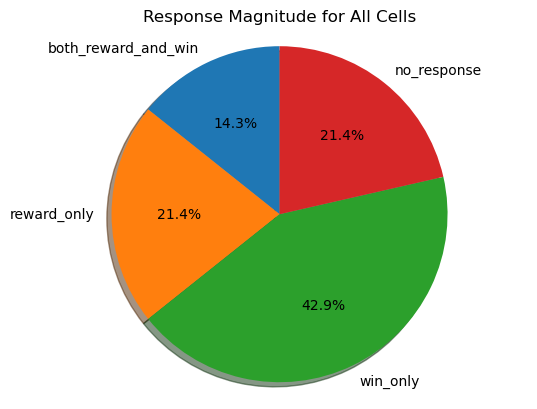

In [87]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

fig1, ax1 = plt.subplots()
ax1.pie(reward_or_win_firing_rate_difference_count.values(), labels=reward_or_win_firing_rate_difference_count.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Response Magnitude for All Cells")
plt.show()

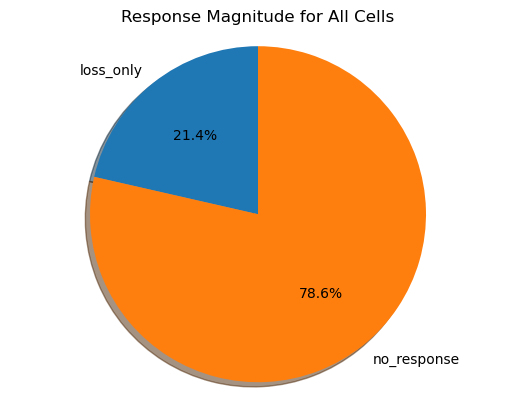

In [88]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

fig1, ax1 = plt.subplots()
ax1.pie(omission_or_loss_firing_rate_difference_count.values(), labels=omission_or_loss_firing_rate_difference_count.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Response Magnitude for All Cells")
plt.show()

# Looking at the firing rate for each 100ms time bin

In [89]:
# The window to look before and after this many timestamps for a given tone
time_stamp_window = trial_one_way_duration * sampling_rate
# dictionary of the tonetime to a list of the good units
within_interval_unit_times = defaultdict(list)

# iterating through the timestamp of each good unit spike
for index, time in enumerate(good_unit_times):
    # getting the corresponding bin for the timestamp
    current_bin = good_unit_bins[index]
        
    # checking number before
    first_tone_time = tone_time_stamps[(current_bin - 1) % len(tone_time_stamps)]
    # checking number after
    second_tone_time = tone_time_stamps[(current_bin) % len(tone_time_stamps)]
    
    # Checking to see if the time is after the start of the tone window
    # Checking to see if the time is before the end of the tone window
    if time >= first_tone_time - time_stamp_window and time <= first_tone_time + time_stamp_window:
        within_interval_unit_times[first_tone_time].append((first_tone_time, index, time, good_unit_all_ids[index]))
    if time >= second_tone_time - time_stamp_window and time <= second_tone_time + time_stamp_window:
        within_interval_unit_times[second_tone_time].append((second_tone_time, index, time, good_unit_all_ids[index]))

#    # Print Statement to check work    
#     if 0 == index % 100:
#         print("Unit Timestamp: {}".format(time))
#         print("Bin: {}".format(current_bin))
#         print("First Tone Time: {}".format(first_tone_time))
#         print("Second Tone Time: {}".format(second_tone_time))



In [90]:
for key, value in within_interval_unit_times.items():
    print(key)
    print(value[:10])
    break

1408048
[(1408048, 3081, 1209073, 64), (1408048, 3082, 1210306, 54), (1408048, 3083, 1210810, 174), (1408048, 3084, 1211041, 52), (1408048, 3085, 1212118, 54), (1408048, 3086, 1212583, 174), (1408048, 3087, 1213435, 183), (1408048, 3088, 1213480, 54), (1408048, 3089, 1214809, 54), (1408048, 3090, 1215336, 174)]


## Seeing which 100ms bin each unit time belongs to

- Creating bins for each 100ms time interval

In [91]:
bin_duration = 0.1

In [92]:
# Seeing how many bins are in the duration
# 0.1 is for 0.1 seconds or 100 miliseconds
bins_with_100ms_range = int(trial_one_way_duration / bin_duration)

In [93]:
bins_with_100ms_range

100

In [94]:
sampling_rate

20000

In [95]:
tone_unit_time_to_interval = {}
# Making a list of all the bins for each tone time stamp
for time in tone_time_stamps:
    tone_unit_time_to_interval[time] = [time + num * (bin_duration * sampling_rate) for num in range(bins_with_100ms_range * -1, bins_with_100ms_range)]

In [96]:
len(tone_unit_time_to_interval[tone_time_stamps[0]])

200

In [97]:
tone_unit_time_to_interval[tone_time_stamps[0]][:25]

[1208048.0,
 1210048.0,
 1212048.0,
 1214048.0,
 1216048.0,
 1218048.0,
 1220048.0,
 1222048.0,
 1224048.0,
 1226048.0,
 1228048.0,
 1230048.0,
 1232048.0,
 1234048.0,
 1236048.0,
 1238048.0,
 1240048.0,
 1242048.0,
 1244048.0,
 1246048.0,
 1248048.0,
 1250048.0,
 1252048.0,
 1254048.0,
 1256048.0]

- Seeing which bin the tone time fits into

In [98]:
all_bin_mapping = None
for key, value in within_interval_unit_times.items():
    unit_fire_time = [fire_time for tone_time, index, fire_time, unit_id in value]
    unit_fire_bin = np.digitize(unit_fire_time, tone_unit_time_to_interval[key], right=True)
    current_tone_bin_map = np.hstack((np.array(value), unit_fire_bin[np.newaxis].T))
    if all_bin_mapping is None:
        all_bin_mapping = current_tone_bin_map
    else: 
        all_bin_mapping = np.vstack((all_bin_mapping, current_tone_bin_map))
    

In [99]:
all_bin_mapping[:5]

array([[1408048,    3081, 1209073,      64,       1],
       [1408048,    3082, 1210306,      54,       2],
       [1408048,    3083, 1210810,     174,       2],
       [1408048,    3084, 1211041,      52,       2],
       [1408048,    3085, 1212118,      54,       3]])

In [100]:
all_bin_mapping[-5:]

array([[60998563,   166246, 61196610,      183,      200],
       [60998563,   166247, 61196720,      174,      200],
       [60998563,   166248, 61196875,      174,      200],
       [60998563,   166249, 61197936,      183,      200],
       [60998563,   166250, 61198104,      183,      200]])

## Calculating Firing Rate

In [101]:
from collections import Counter, defaultdict

- Creating a reference for all the tone bin combinations to each tone
    - This is because we need a unique identifier for each tone and bin combination. So we will just add the numbers

In [102]:
tone_bin_for_index = all_bin_mapping[:,0] + all_bin_mapping[:,4]

In [103]:
tone_bin_to_tone = np.hstack((tone_bin_for_index[np.newaxis].T, all_bin_mapping[:,0][np.newaxis].T))

In [104]:
tone_bin_to_tone

array([[ 1408049,  1408048],
       [ 1408050,  1408048],
       [ 1408050,  1408048],
       ...,
       [60998763, 60998563],
       [60998763, 60998563],
       [60998763, 60998563]])

In [105]:
tone_bin_to_tone = dict(zip(tone_bin_to_tone[:,0], tone_bin_to_tone[:,1]))

In [106]:
tone_bin_to_tone

{1408049: 1408048,
 1408050: 1408048,
 1408051: 1408048,
 1408052: 1408048,
 1408053: 1408048,
 1408054: 1408048,
 1408055: 1408048,
 1408056: 1408048,
 1408057: 1408048,
 1408058: 1408048,
 1408059: 1408048,
 1408060: 1408048,
 1408061: 1408048,
 1408062: 1408048,
 1408063: 1408048,
 1408064: 1408048,
 1408065: 1408048,
 1408066: 1408048,
 1408067: 1408048,
 1408068: 1408048,
 1408069: 1408048,
 1408070: 1408048,
 1408071: 1408048,
 1408072: 1408048,
 1408073: 1408048,
 1408074: 1408048,
 1408075: 1408048,
 1408076: 1408048,
 1408077: 1408048,
 1408078: 1408048,
 1408079: 1408048,
 1408080: 1408048,
 1408081: 1408048,
 1408082: 1408048,
 1408083: 1408048,
 1408084: 1408048,
 1408085: 1408048,
 1408086: 1408048,
 1408087: 1408048,
 1408088: 1408048,
 1408089: 1408048,
 1408090: 1408048,
 1408091: 1408048,
 1408092: 1408048,
 1408093: 1408048,
 1408094: 1408048,
 1408095: 1408048,
 1408096: 1408048,
 1408097: 1408048,
 1408098: 1408048,
 1408099: 1408048,
 1408100: 1408048,
 1408101: 14

In [107]:
tone_bin_for_index

array([ 1408049,  1408050,  1408050, ..., 60998763, 60998763, 60998763])

- Getting the number of times each neuron fires

In [108]:
firing_counts = defaultdict(lambda: defaultdict(dict))
for tone_time, index, firing_time, unit_id, bin_index in all_bin_mapping:
    tone_bin = tone_time + bin_index
    if firing_counts[unit_id][tone_bin]:
        firing_counts[unit_id][tone_bin] += 1
    else:
        firing_counts[unit_id][tone_bin] = 1

In [109]:
firing_rate_df = pd.DataFrame.from_dict(firing_counts)

In [110]:
firing_rate_df = firing_rate_df.fillna(value=0)

In [111]:
firing_rate_df.head()

,64,54,174,52,183,156,24,20,163,59,188,182,16,50
1408049,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1408054,1.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1408056,1.0,1.0,3.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1408057,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1408058,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
firing_rate_df.loc[:].values

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 2., ..., 0., 0., 0.],
       [1., 1., 3., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

- Classifying each time stamp

In [113]:
all_bin_mapping

array([[ 1408048,     3081,  1209073,       64,        1],
       [ 1408048,     3082,  1210306,       54,        2],
       [ 1408048,     3083,  1210810,      174,        2],
       ...,
       [60998563,   166248, 61196875,      174,      200],
       [60998563,   166249, 61197936,      183,      200],
       [60998563,   166250, 61198104,      183,      200]])

In [114]:
all_bin_mapping[:, 0]

array([ 1408048,  1408048,  1408048, ..., 60998563, 60998563, 60998563])

In [115]:
all_bin_mapping[:, 2]

array([ 1209073,  1210306,  1210810, ..., 61196875, 61197936, 61198104])

- Making a dictionary that maps all the firing times to the corresponding tone

In [116]:
fire_to_tone_time = dict(zip(all_bin_mapping[:, 2], all_bin_mapping[:, 0]))

In [117]:
fire_to_tone_time

{1209073: 1408048,
 1210306: 1408048,
 1210810: 1408048,
 1211041: 1408048,
 1212118: 1408048,
 1212583: 1408048,
 1213435: 1408048,
 1213480: 1408048,
 1214809: 1408048,
 1215336: 1408048,
 1217004: 1408048,
 1217080: 1408048,
 1217382: 1408048,
 1217972: 1408048,
 1218058: 1408048,
 1218225: 1408048,
 1218979: 1408048,
 1219153: 1408048,
 1219639: 1408048,
 1219732: 1408048,
 1220186: 1408048,
 1220679: 1408048,
 1220975: 1408048,
 1221054: 1408048,
 1221090: 1408048,
 1221270: 1408048,
 1221301: 1408048,
 1221553: 1408048,
 1222193: 1408048,
 1222491: 1408048,
 1222531: 1408048,
 1223020: 1408048,
 1223563: 1408048,
 1223689: 1408048,
 1223868: 1408048,
 1224042: 1408048,
 1224987: 1408048,
 1225021: 1408048,
 1225212: 1408048,
 1225476: 1408048,
 1225875: 1408048,
 1226741: 1408048,
 1227100: 1408048,
 1227376: 1408048,
 1227872: 1408048,
 1227916: 1408048,
 1228830: 1408048,
 1229266: 1408048,
 1229525: 1408048,
 1229696: 1408048,
 1229755: 1408048,
 1230800: 1408048,
 1232408: 14

In [118]:
firing_rate_df = firing_rate_df.reset_index()

- Labeling which tone time that fire time belongs to

In [119]:
firing_rate_df["tone_time"] = firing_rate_df["index"].map(tone_bin_to_tone)

In [120]:
firing_rate_df.head()

,index,64,54,174,52,183,156,24,20,163,59,188,182,16,50,tone_time
0,1408049,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1408048
1,1408054,1.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1408048
2,1408056,1.0,1.0,3.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1408048
3,1408057,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1408048
4,1408058,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1408048


In [121]:
firing_rate_df["bin"] = firing_rate_df["index"] - firing_rate_df["tone_time"]

## Categorizing Rewarded vs Omitted for Training

In [122]:
tone_time_stamps_df

,tone_time_stamp,tone_category
0,1408048,rewarded
1,3008051,rewarded
2,4808043,rewarded
3,6408042,omission
4,7908040,rewarded
5,9908037,rewarded
6,11808035,rewarded
7,13608031,rewarded
8,15208032,omission
9,17008029,rewarded


In [123]:

tone_timestamp_to_trial_type = pd.Series(tone_time_stamps_df["tone_category"].values, index=tone_time_stamps_df["tone_time_stamp"]).to_dict()

In [124]:
tone_timestamp_to_trial_type

{1408048: 'rewarded',
 3008051: 'rewarded',
 4808043: 'rewarded',
 6408042: 'omission',
 7908040: 'rewarded',
 9908037: 'rewarded',
 11808035: 'rewarded',
 13608031: 'rewarded',
 15208032: 'omission',
 17008029: 'rewarded',
 19008027: 'rewarded',
 20808026: 'omission',
 23208023: 'rewarded',
 25008021: 'rewarded',
 27998597: 'loss',
 29598593: 'win',
 31398591: 'win',
 32998593: 'win',
 34498591: 'win',
 36498588: 'win',
 38398586: 'win',
 40198584: 'win',
 41798580: 'win',
 43598581: 'win',
 45598579: 'win',
 47398577: 'win',
 49798572: 'loss',
 51598570: 'loss',
 53298568: 'loss',
 55098566: 'loss',
 56998564: 'win',
 59398564: 'loss',
 60998563: 'loss'}

In [125]:
firing_rate_df["tone_label"] = firing_rate_df["tone_time"].map(tone_timestamp_to_trial_type)

## Categorizing win vs loss for competition

In [126]:
firing_rate_df.head()

,index,64,54,174,52,183,156,24,20,163,59,188,182,16,50,tone_time,bin,tone_label
0,1408049,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1408048,1,rewarded
1,1408054,1.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1408048,6,rewarded
2,1408056,1.0,1.0,3.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1408048,8,rewarded
3,1408057,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1408048,9,rewarded
4,1408058,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1408048,10,rewarded


- We will be averaging using the bin number, because we are curious about how the firing rate changes 10 seconds before and after at each 100ms bin(averaging across sessions)
    - And we will be averaging across trials that have the same trial type

In [127]:
averaged_firing_rate_df = firing_rate_df.groupby(['bin', 'tone_label']).mean()

In [128]:
averaged_firing_rate_df

index        64        54       174        52  \
bin tone_label                                                         
1   loss        5.117000e+07  0.285714  1.285714  1.428571  0.000000   
    omission    1.414137e+07  0.333333  2.000000  1.666667  0.000000   
    rewarded    1.242622e+07  0.454545  0.818182  1.090909  0.181818   
    win         3.991525e+07  0.166667  1.000000  1.833333  0.083333   
2   loss        5.117000e+07  0.428571  1.142857  1.142857  0.000000   
...                      ...       ...       ...       ...       ...   
199 win         3.991545e+07  0.500000  0.416667  2.333333  0.000000   
200 loss        5.117020e+07  0.285714  0.714286  1.000000  0.285714   
    omission    1.414157e+07  0.000000  0.333333  2.000000  0.000000   
    rewarded    1.242642e+07  0.181818  0.909091  1.818182  0.090909   
    win         3.991545e+07  0.333333  0.500000  1.916667  0.083333   

                     183       156        24        20       163        59  \
bin tone_label                                                               
1   loss        0.428571  0.000000  0.571429  0.857143  0.000000  0.428571   
    omission    1.000000  0.333333  0.666667  0.000000  0.000000  0.666667   
    rewarded    0.818182  0.181818  0.727273  0.727273  0.000000  0.181818   
    win         0.750000  0.000000  0.666667  0.500000  0.250000  0.333333   
2   loss        1.000000  0.000000  0.571429  0.857143  0.142857  0.142857   
...                  ...       ...       ...       ...       ...       ...   
199 win         0.666667  0.000000  1.333333  1.166667  0.166667  0.083333   
200 loss        1.571429  0.142857  0.714286  0.571429  0.000000  0.285714   
    omission    0.333333  0.000000  0.666667  0.333333  0.000000  0.333333   
    rewarded    0.818182  0.272727  0.636364  1.454545  0.363636  0.272727   
    win         1.166667  0.083333  1.250000  1.333333  0.083333  0.083333   

                     188       182        16        50     tone_time  
bin tone_label                                                        
1   loss        0.142857  0.142857  0.000000  0.285714  5.117000e+07  
    omission    0.333333  0.000000  0.000000  0.000000  1.414137e+07  
    rewarded    0.090909  0.000000  0.090909  0.000000  1.242622e+07  
    win         0.000000  0.083333  0.000000  0.083333  3.991525e+07  
2   loss        0.000000  0.000000  0.142857  0.000000  5.117000e+07  
...                  ...       ...       ...       ...           ...  
199 win         0.000000  0.000000  0.416667  0.083333  3.991525e+07  
200 loss        0.000000  0.000000  0.000000  0.142857  5.117000e+07  
    omission    0.000000  0.000000  0.000000  0.000000  1.414137e+07  
    rewarded    0.090909  0.000000  0.090909  0.090909  1.242622e+07  
    win         0.000000  0.000000  0.166667  0.000000  3.991525e+07  

[800 rows x 16 columns]

In [129]:
averaged_firing_rate_df = averaged_firing_rate_df.reset_index()

In [130]:
averaged_firing_rate_df

,bin,tone_label,index,64,54,174,52,183,156,24,20,163,59,188,182,16,50,tone_time
0,1,loss,5.117000e+07,0.285714,1.285714,1.428571,0.000000,0.428571,0.000000,0.571429,0.857143,0.000000,0.428571,0.142857,0.142857,0.000000,0.285714,5.117000e+07
1,1,omission,1.414137e+07,0.333333,2.000000,1.666667,0.000000,1.000000,0.333333,0.666667,0.000000,0.000000,0.666667,0.333333,0.000000,0.000000,0.000000,1.414137e+07
2,1,rewarded,1.242622e+07,0.454545,0.818182,1.090909,0.181818,0.818182,0.181818,0.727273,0.727273,0.000000,0.181818,0.090909,0.000000,0.090909,0.000000,1.242622e+07
3,1,win,3.991525e+07,0.166667,1.000000,1.833333,0.083333,0.750000,0.000000,0.666667,0.500000,0.250000,0.333333,0.000000,0.083333,0.000000,0.083333,3.991525e+07
4,2,loss,5.117000e+07,0.428571,1.142857,1.142857,0.000000,1.000000,0.000000,0.571429,0.857143,0.142857,0.142857,0.000000,0.000000,0.142857,0.000000,5.117000e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,199,win,3.991545e+07,0.500000,0.416667,2.333333,0.000000,0.666667,0.000000,1.333333,1.166667,0.166667,0.083333,0.000000,0.000000,0.416667,0.083333,3.991525e+07
796,200,loss,5.117020e+07,0.285714,0.714286,1.000000,0.285714,1.571429,0.142857,0.714286,0.571429,0.000000,0.285714,0.000000,0.000000,0.000000,0.142857,5.117000e+07
797,200,omission,1.414157e+07,0.000000,0.333333,2.000000,0.000000,0.333333,0.000000,0.666667,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,1.414137e+07
798,200,rewarded,1.242642e+07,0.181818,0.909091,1.818182,0.090909,0.818182,0.272727,0.636364,1.454545,0.363636,0.272727,0.090909,0.000000,0.090909,0.090909,1.242622e+07


In [131]:
averaged_firing_rate_df["tone_label"].unique()

array(['loss', 'omission', 'rewarded', 'win'], dtype=object)

- Removing all the columns that don't have firing rate info
    - AKA the index and the tone time

In [133]:
numerical_columns = [col for col in averaged_firing_rate_df.columns if type(col) == int]

- Transposing so that we get the spike unit number as the row, and the bin and trial type as the column

In [134]:
transposed_averaged_firing_rate_df = averaged_firing_rate_df[numerical_columns].transpose()

In [135]:
transposed_averaged_firing_rate_df = transposed_averaged_firing_rate_df.reset_index()

In [136]:
transposed_averaged_firing_rate_df = transposed_averaged_firing_rate_df.sort_values(["index"]).reset_index(drop=True)

In [137]:
transposed_averaged_firing_rate_df

,index,0,1,2,3,4,5,6,7,8,...,790,791,792,793,794,795,796,797,798,799
0,16,0.000000,0.000000,0.090909,0.000000,0.142857,0.000000,0.000000,0.000000,0.285714,...,0.181818,0.416667,0.000000,0.000000,0.000000,0.416667,0.000000,0.000000,0.090909,0.166667
1,20,0.857143,0.000000,0.727273,0.500000,0.857143,0.666667,0.272727,1.000000,0.571429,...,1.363636,0.916667,0.857143,1.333333,0.909091,1.166667,0.571429,0.333333,1.454545,1.333333
2,24,0.571429,0.666667,0.727273,0.666667,0.571429,1.666667,0.727273,0.916667,0.285714,...,0.454545,0.916667,0.857143,0.666667,0.363636,1.333333,0.714286,0.666667,0.636364,1.250000
3,50,0.285714,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.500000,0.142857,...,0.181818,0.083333,0.428571,0.000000,0.181818,0.083333,0.142857,0.000000,0.090909,0.000000
4,52,0.000000,0.000000,0.181818,0.083333,0.000000,0.333333,0.181818,0.000000,0.142857,...,0.090909,0.083333,0.142857,0.000000,0.272727,0.000000,0.285714,0.000000,0.090909,0.083333
5,54,1.285714,2.000000,0.818182,1.000000,1.142857,0.333333,1.363636,0.750000,0.714286,...,0.363636,0.583333,0.714286,0.666667,0.454545,0.416667,0.714286,0.333333,0.909091,0.500000
6,59,0.428571,0.666667,0.181818,0.333333,0.142857,0.333333,0.181818,0.250000,0.428571,...,0.181818,0.250000,0.285714,0.666667,0.090909,0.083333,0.285714,0.333333,0.272727,0.083333
7,64,0.285714,0.333333,0.454545,0.166667,0.428571,0.333333,0.272727,0.250000,0.428571,...,0.272727,0.083333,0.000000,0.333333,0.727273,0.500000,0.285714,0.000000,0.181818,0.333333
8,156,0.000000,0.333333,0.181818,0.000000,0.000000,0.333333,0.000000,0.083333,0.000000,...,0.090909,0.166667,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.272727,0.083333
9,163,0.000000,0.000000,0.000000,0.250000,0.142857,0.000000,0.181818,0.500000,0.285714,...,0.181818,0.083333,0.000000,0.333333,0.181818,0.166667,0.000000,0.000000,0.363636,0.083333


In [138]:
resetted_averaged_firing_rate_array = transposed_averaged_firing_rate_df.values

In [139]:
resetted_averaged_firing_rate_array

array([[1.60000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 9.09090909e-02, 1.66666667e-01],
       [2.00000000e+01, 8.57142857e-01, 0.00000000e+00, ...,
        3.33333333e-01, 1.45454545e+00, 1.33333333e+00],
       [2.40000000e+01, 5.71428571e-01, 6.66666667e-01, ...,
        6.66666667e-01, 6.36363636e-01, 1.25000000e+00],
       ...,
       [1.82000000e+02, 1.42857143e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.83000000e+02, 4.28571429e-01, 1.00000000e+00, ...,
        3.33333333e-01, 8.18181818e-01, 1.16666667e+00],
       [1.88000000e+02, 1.42857143e-01, 3.33333333e-01, ...,
        0.00000000e+00, 9.09090909e-02, 0.00000000e+00]])

# PCA with Neuron Rows

## Standarizing the Data

- TODO: Check why the 0s are being scaled differently

In [140]:
from sklearn.preprocessing import StandardScaler

In [141]:
# Separating out the features
x = resetted_averaged_firing_rate_array#.loc[:].values# Separating out the target
resetted_averaged_firing_rate_array = StandardScaler().fit_transform(x)

## Calculating the PCA

In [142]:
from sklearn.decomposition import PCA


In [143]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(resetted_averaged_firing_rate_array)
principal_df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [144]:
principal_df.head()

,principal component 1,principal component 2
0,-17.098987,0.445708
1,19.266457,-15.591019
2,8.637832,-1.511515
3,-16.784481,-1.384911
4,-15.116570,-1.366540


In [145]:
principal_df["principal component 1"]

0    -17.098987
1     19.266457
2      8.637832
3    -16.784481
4    -15.116570
5     18.099673
6     -9.347458
7     -8.960363
8    -17.869166
9    -13.000282
10    61.058235
11   -20.436902
12    30.793361
13   -19.241348
Name: principal component 1, dtype: float64

In [146]:
pc1_product = transposed_averaged_firing_rate_df.reset_index().multiply(principal_df["principal component 1"], axis="index")

In [147]:
pc1_product

,level_0,index,0,1,2,3,4,5,6,7,...,790,791,792,793,794,795,796,797,798,799
0,-0.000000,-273.583796,-0.000000,-0.000000,-1.554453,-0.000000,-2.442712,-0.000000,-0.000000,-0.000000,...,-3.108907,-7.124578,-0.000000,-0.000000,-0.000000,-7.124578,-0.000000,-0.000000,-1.554453,-2.849831
1,19.266457,385.329136,16.514106,0.000000,14.011969,9.633228,16.514106,12.844305,5.254488,19.266457,...,26.272441,17.660919,16.514106,25.688609,17.514961,22.477533,11.009404,6.422152,28.023937,25.688609
2,17.275663,207.307959,4.935904,5.758554,6.282059,5.758554,4.935904,14.396386,6.282059,7.918012,...,3.926287,7.918012,7.403856,5.758554,3.141030,11.517109,6.169880,5.758554,5.496802,10.797290
3,-50.353443,-839.224042,-4.795566,-0.000000,-0.000000,-1.398707,-0.000000,-0.000000,-0.000000,-8.392240,...,-3.051724,-1.398707,-7.193349,-0.000000,-3.051724,-1.398707,-2.397783,-0.000000,-1.525862,-0.000000
4,-60.466278,-786.061620,-0.000000,-0.000000,-2.748467,-1.259714,-0.000000,-5.038857,-2.748467,-0.000000,...,-1.374234,-1.259714,-2.159510,-0.000000,-4.122701,-0.000000,-4.319020,-0.000000,-1.374234,-1.259714
5,90.498363,977.382318,23.271008,36.199345,14.808823,18.099673,20.685340,6.033224,24.681372,13.574754,...,6.581699,10.558142,12.928338,12.066448,8.227124,7.541530,12.928338,6.033224,16.454248,9.049836
6,-56.084749,-551.500029,-4.006053,-6.231639,-1.699538,-3.115819,-1.335351,-3.115819,-1.699538,-2.336865,...,-1.699538,-2.336865,-2.670702,-6.231639,-0.849769,-0.778955,-2.670702,-3.115819,-2.549307,-0.778955
7,-62.722539,-573.463212,-2.560104,-2.986788,-4.072892,-1.493394,-3.840155,-2.986788,-2.443735,-2.240091,...,-2.443735,-0.746697,-0.000000,-2.986788,-6.516627,-4.480181,-2.560104,-0.000000,-1.629157,-2.986788
8,-142.953327,-2787.589874,-0.000000,-5.956389,-3.248939,-0.000000,-0.000000,-5.956389,-0.000000,-1.489097,...,-1.624470,-2.978194,-0.000000,-0.000000,-0.000000,-0.000000,-2.552738,-0.000000,-4.873409,-1.489097
9,-117.002540,-2119.045999,-0.000000,-0.000000,-0.000000,-3.250071,-1.857183,-0.000000,-2.363688,-6.500141,...,-2.363688,-1.083357,-0.000000,-4.333427,-2.363688,-2.166714,-0.000000,-0.000000,-4.727375,-1.083357


In [148]:
pc1_product.mean()

level_0     10.186917
index      182.998510
0            9.151013
1           10.923313
2            7.988064
              ...    
795         13.470369
796          8.932505
797         10.534217
798         11.871537
799         13.431562
Length: 802, dtype: float64

In [149]:
pc2_product = transposed_averaged_firing_rate_df.reset_index().multiply(principal_df["principal component 2"], axis="index")

In [150]:
pc2_product

,level_0,index,0,1,2,3,4,5,6,7,...,790,791,792,793,794,795,796,797,798,799
0,0.000000,7.131320,0.000000,0.000000,0.040519,0.000000,0.063673,0.000000,0.000000,0.000000,...,0.081038,0.185711,0.000000,0.000000,0.000000,0.185711,0.000000,0.000000,0.040519,0.074285
1,-15.591019,-311.820380,-13.363731,-0.000000,-11.338923,-7.795509,-13.363731,-10.394013,-4.252096,-15.591019,...,-21.260480,-14.291767,-13.363731,-20.788025,-14.173654,-18.189522,-8.909154,-5.197006,-22.677846,-20.788025
2,-3.023029,-36.276354,-0.863723,-1.007676,-1.099283,-1.007676,-0.863723,-2.519191,-1.099283,-1.385555,...,-0.687052,-1.385555,-1.295584,-1.007676,-0.549642,-2.015353,-1.079653,-1.007676,-0.961873,-1.889393
3,-4.154734,-69.245563,-0.395689,-0.000000,-0.000000,-0.115409,-0.000000,-0.000000,-0.000000,-0.692456,...,-0.251802,-0.115409,-0.593533,-0.000000,-0.251802,-0.115409,-0.197844,-0.000000,-0.125901,-0.000000
4,-5.466161,-71.060098,-0.000000,-0.000000,-0.248462,-0.113878,-0.000000,-0.455513,-0.248462,-0.000000,...,-0.124231,-0.113878,-0.195220,-0.000000,-0.372693,-0.000000,-0.390440,-0.000000,-0.124231,-0.113878
5,101.209458,1093.062147,26.025289,40.483783,16.561548,20.241892,23.133590,6.747297,27.602579,15.181419,...,7.360688,11.807770,14.458494,13.494594,9.200860,8.434122,14.458494,6.747297,18.401720,10.120946
6,7.078572,69.605960,0.505612,0.786508,0.214502,0.393254,0.168537,0.393254,0.214502,0.294941,...,0.214502,0.294941,0.337075,0.786508,0.107251,0.098314,0.337075,0.393254,0.321753,0.098314
7,-2.763218,-25.263706,-0.112784,-0.131582,-0.179430,-0.065791,-0.169177,-0.131582,-0.107658,-0.098686,...,-0.107658,-0.032895,-0.000000,-0.131582,-0.287088,-0.197373,-0.112784,-0.000000,-0.071772,-0.131582
8,-6.764438,-131.906549,-0.000000,-0.281852,-0.153737,-0.000000,-0.000000,-0.281852,-0.000000,-0.070463,...,-0.076869,-0.140926,-0.000000,-0.000000,-0.000000,-0.000000,-0.120794,-0.000000,-0.230606,-0.070463
9,-44.880012,-812.826887,-0.000000,-0.000000,-0.000000,-1.246667,-0.712381,-0.000000,-0.906667,-2.493334,...,-0.906667,-0.415556,-0.000000,-1.662223,-0.906667,-0.831111,-0.000000,-0.000000,-1.813334,-0.415556


In [151]:
pc2_product.mean()

level_0     7.338722
index      42.660824
0           0.077854
1           2.650669
2           0.377667
             ...    
795        -2.162723
796         1.525088
797        -1.343368
798        -1.091465
799        -1.114886
Length: 802, dtype: float64

In [152]:
pc_product = pd.concat([pc1_product.mean(), pc2_product.mean()], axis=1).reset_index()

In [153]:
pc_product = pc_product[pc_product["bin"].apply(lambda x: isinstance(x, int))]


KeyError: 'bin'

In [ ]:
pc_product["before_during_after"] = pc_product["bin"].apply(lambda x: "-5s to 0s" if x < 50 else ("0s to 5s" if 50 <= x < 100 else "5s to 10s"))

In [ ]:
pc_product

In [ ]:
pc_product["outcome_and_when"] = pc_product.apply(lambda x: x["before_during_after"] + " " + x["tone_label"], axis=1)

In [ ]:
pc_product

In [ ]:
omission_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "omission" in name]
rewarded_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "rewarded" in name]
win_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "win" in name]
loss_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "loss" in name]


In [ ]:
omission_pc = pc_product[pc_product["tone_label"] == "Omission"]

In [ ]:
omission_pc

In [ ]:
averaged_omission_pc = omission_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()

In [ ]:
averaged_omission_pc

In [ ]:
rewarded_pc = pc_product[pc_product["rewarded_omission_win_loss_catgeory"] == "Rewarded"]

In [ ]:
averaged_rewarded_pc = rewarded_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()

In [ ]:
plt.scatter(averaged_omission_pc[0], averaged_omission_pc[1], c=averaged_omission_pc["index"], cmap='Reds')
plt.scatter(averaged_rewarded_pc[0], averaged_rewarded_pc[1], c=averaged_rewarded_pc["index"], cmap='Greens')

plt.show()

In [ ]:
plt.plot(averaged_omission_pc[0], averaged_omission_pc[1], '-o', c="red")
plt.plot(averaged_rewarded_pc[0], averaged_rewarded_pc[1], '-o', c="blue")

plt.show()

In [ ]:
all_categories = sorted(pc_product["outcome_and_when"].unique())

In [ ]:
all_categories

In [ ]:
win: blue
loss: yellow
rewarded: green
omission: red

In [ ]:
all_colors = ["gold", "pink", "lightgreen", "lightblue", "orange", "red", "green", "cyan", "darkorange", "darkred", "darkgreen", "darkcyan"]


In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = rewarded_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(all_categories, all_colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(all_categories)
ax.grid()

## Looking at each plot individually across time

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["pink", "red", "darkred"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = rewarded_categories
colors = ["lightgreen", "green", "darkgreen"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = win_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = loss_categories
colors = ["gold", "orange", "darkorange"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
Message List

    Monday
    Hey Nancy! Sounds like a plan with processi... by Iwata,Ryo L
    Iwata,Ryo LMonday 2:40 PM

    Hey Nancy! Sounds like a plan with processing the other recordings! Would there be an opportunity to record from other animals? I know it'll take at least a month with surgerys and training the mice. If not, then I'll try thinking of other things to look at with our current recordings like incorporating SLEAP and what not.

     

    As for hours, I didn't have the chance to work this weekend. But will update you before with any extra hours I do this week or weekend.
    Profile picture of Padilla-Coreano, Nancy.
    how many good recordings do you have? I thi... by Padilla-Coreano, Nancy
    Padilla-Coreano, NancyMonday 2:44 PM

    how many good recordings do you have? I think you had 2 good animals and ran them against all their cagemates, so it should be 6 good recordings from 2 mice?
    6 recordings is not a lot but could be enou... by Padilla-Coreano, Nancy
    Padilla-Coreano, Nancy
    Monday 2:45 PM

    6 recordings is not a lot but could be enough for the poster
    start processing together the alone+comp se... by Padilla-Coreano, Nancy
    Padilla-Coreano, Nancy
    Monday 2:46 PM

    start processing together the alone+comp sessions for those 6 good recordings and i will make a meeting with you where we will make a game plan for the analysis. The meeting wont be until Jan 19 because I have to focus on this presentation but till then its a good idea to 1. spike sort all the good sessions 2. try to run videos in sleap
    Tuesday
    Profile picture of Padilla-Coreano, Nancy.
    hey Leo, can you remind me when is your pos... by Padilla-Coreano, Nancy
    Padilla-Coreano, NancyTuesday 3:42 PM

    hey Leo, can you remind me when is your poster presentation in the UF research day?
    It's on February 28th, thank you for checki... by Iwata,Ryo L
    Iwata,Ryo LTuesday 5:37 PM

    It's on February 28th, thank you for checking in about that! I can make a rough timeline today or tomorrow, and have you make corrections or suggestions if that works.

Yesterday
Hey Nancy! Here's the tentative plans I had... by Iwata,Ryo L
Iwata,Ryo LYesterday 5:38 PM

Hey Nancy! Here's the tentative plans I had for the poster: https://garnet-rotate-01f.notion.site/UF-MED-Poster-Timeline-64cfc246010f4b8ab1aae2abd53b721d

 

I still need to read up/think of ways to analyze the ephys and the SLEAP data. So I'll add more as things come up. But it includes a rough timeline I had in mind. I've finished the spike sorting for the ephys recordings and currently trying to get the the predictions for SLEAP on the competition videos that I've reencoded. I'm not sure about the quality of the spike sorting or the ephys recording, so I'll send you some photos or show you after our meetings tomorrow.
Url Preview for UF MED Poster Timeline
UF MED Poster Timeline

https://research.med.ufl.edu/2023-com-celebration-of-research/
garnet-rotate-01f.notion.site
Profile picture of Padilla-Coreano, Nancy.
I will look at them closely tomorrow mornin by Padilla-Coreano, Nancy
Padilla-Coreano, NancyYesterday 5:58 PM

I will look at them closely tomorrow morning
in the meantime I have a favor to ask. I ne... by Padilla-Coreano, Nancy
Padilla-Coreano, Nancy
Yesterday 5:58 PM

in the meantime I have a favor to ask. I need an example of all the LFPs we recorded simultaneously from different brain regions
I think its 4 regions? by Padilla-Coreano, Nancy
Padilla-Coreano, Nancy
Yesterday 5:59 PM

I think its 4 regions?
or 5? by Padilla-Coreano, Nancy
Padilla-Coreano, Nancy
Yesterday 5:59 PM

or 5?
counting the mPFC by Padilla-Coreano, Nancy
Padilla-Coreano, Nancy
Yesterday 5:59 PM

counting the mPFC
Ill make a cartoon tomorrow morning so you ... by Padilla-Coreano, Nancy
Padilla-Coreano, Nancy
Yesterday 5:59 PM

Ill make a cartoon tomorrow morning so you know how to make the plot
its for my talk, so i need it asap! by Padilla-Coreano, Nancy
Padilla-Coreano, Nancy
Yesterday 5:59 PM

its for my talk, so i need it asap!
im recording the final version Wed morning ... by Padilla-Coreano, Nancy
Padilla-Coreano, Nancy
Yesterday 6:00 PM

im recording the final version Wed morning so it needs to be finalize by Monday so I can memorize it
Today
Sounds like a plan Nancy! Would it be a plo... by Iwata,Ryo L
Iwata,Ryo L11:40 AM
Sounds like a plan Nancy! Would it be a plot comparing the power for each condition and each region. And definitely can try to get it done by today so that you have the weekend to practice.
Profile picture of Padilla-Coreano, Nancy.
No its even simpler than that I left u ... by Padilla-Coreano, Nancy
Padilla-Coreano, Nancy12:02 PM
No its even simpler than that
I left u written instructions on your desk
Thank you!! by Padilla-Coreano, Nancy
Padilla-Coreano, Nancy
12:03 PM
Thank you!!
Hey Nancy! So for the LFP plots, I filtered... by Iwata,Ryo L
Iwata,Ryo L4:13 PM
Edited

Hey Nancy! So for the LFP plots, I filtered for frequencies between 1 and 300. And then took the common median reference. I have it in my notes that the EIB channels for the brain regions were:

    MD1, vHPC17, BLA16, LH15

So that would make the channels on Trodes(Which I converted with your useful chart: https://garnet-rotate-01f.notion.site/7f0e40b5251e4176ad4673389d13a36b?v=3624312cf3db4ab694be679b360660fc) :

    MD32, vHPC16, BLA17, LH16

And to get the indexes in Spikeinterface, I just added 1 to each. I'll continue looking for a segment with good noise and reformat the plot. Let me know if there's any steps that I need to add or correct!

 

image

 
Url Preview for Mapping of channels from EIB32 narrow to spikegadgets
Mapping of channels from EIB32 narrow to spikegadgets

A new tool for teams & individuals that blends everyday work apps into one.
garnet-rotate-01f.notion.site

has context menu


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['-5s to 0s Omission', '-5s to 0s Rewarded', '-5s to 0s Loss', '-5s to 0s Win']
colors = ["pink", "lightgreen", "gold", "lightblue"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['0s to 5s Omission', '0s to 5s Rewarded', '0s to 5s Loss', '0s to 5s Win']
colors = ["red", "green", "orange", "cyan"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
all_colors = ["gold", "pink", "lightgreen", "lightblue", "orange", "red", "green", "cyan", "darkorange", "darkred", "darkgreen", "darkcyan"]


In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['5s to 10s Omission', '5s to 10s Rewarded', '5s to 10s Loss', '5s to 10s Win']
colors = ["darkred", "darkgreen", "darkorange", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
firing_rate_and_pca_df = pd.concat([transposed_averaged_firing_rate_df.reset_index(), principal_df], axis=1)

In [ ]:
firing_rate_and_pca_df

In [ ]:
firing_rate_and_pca_df

In [ ]:
principal_df.shape

In [ ]:
firing_rate_and_pca_df["before_during_after"] = firing_rate_and_pca_df["bin"].apply(lambda x: "-5s to 0s" if x < 50 else ("0s to 5s" if 50 <= x < 100 else "5s to 10s"))

In [ ]:
firing_rate_and_pca_df["outcome_and_when"] = firing_rate_and_pca_df.apply(lambda x: x["before_during_after"] + " " + x["rewarded_category"], axis=1)

In [ ]:
firing_rate_and_pca_df

In [ ]:
sorted(firing_rate_and_pca_df["outcome_and_when"].unique())

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["pink", "red", "darkred"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
['-5s to 0s Omission',
 '-5s to 0s Rewarded',
 '0s to 5s Omission',
 '0s to 5s Rewarded',
 '5s to 10s Omission',
 '5s to 10s Rewarded']

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['-5s to 0s Omission', '-5s to 0s Rewarded']
colors = ["pink", "lightblue"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['0s to 5s Omission', '0s to 5s Rewarded']
colors = ["red", "cyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['5s to 10s Omission', '5s to 10s Rewarded']
colors = ["darkred", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# PCA with Time Bin Rows

## Standarizing the Data

- TODO: Check why the 0s are being scaled differently

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Separating out the features
x = resetted_averaged_firing_rate_array#.loc[:].values# Separating out the target
resetted_averaged_firing_rate_array = StandardScaler().fit_transform(x)

## Calculating the PCA

In [ ]:
from sklearn.decomposition import PCA


In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(resetted_averaged_firing_rate_array)
principal_df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
principal_df.head()

In [ ]:
principal_df.shape

In [ ]:
principal_df.shape

In [ ]:
firing_rate_and_pca_df = pd.concat([resetted_averaged_firing_rate_df, principal_df], axis=1)

In [ ]:
firing_rate_and_pca_df["before_during_after"] = firing_rate_and_pca_df["bin"].apply(lambda x: "-5s to 0s" if x < 50 else ("0s to 5s" if 50 <= x < 100 else "5s to 10s"))

In [ ]:
firing_rate_and_pca_df["outcome_and_when"] = firing_rate_and_pca_df.apply(lambda x: x["before_during_after"] + " " + x["rewarded_category"], axis=1)

In [ ]:
firing_rate_and_pca_df

In [ ]:
sorted(firing_rate_and_pca_df["outcome_and_when"].unique())

In [ ]:
omission_categories = [name for name in sorted(firing_rate_and_pca_df["outcome_and_when"].unique()) if "Omission" in name]
rewarded_categories = [name for name in sorted(firing_rate_and_pca_df["outcome_and_when"].unique()) if "Rewarded" in name]


In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["pink", "red", "darkred"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
['-5s to 0s Omission',
 '-5s to 0s Rewarded',
 '0s to 5s Omission',
 '0s to 5s Rewarded',
 '5s to 10s Omission',
 '5s to 10s Rewarded']

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['-5s to 0s Omission', '-5s to 0s Rewarded']
colors = ["pink", "lightblue"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['0s to 5s Omission', '0s to 5s Rewarded']
colors = ["red", "cyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['5s to 10s Omission', '5s to 10s Rewarded']
colors = ["darkred", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = firing_rate_and_pca_df['outcome_and_when'] == target
    ax.scatter(firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 1']
               , firing_rate_and_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
raise ValueError()

# From DIN to Video

- State 1 is when the MED-PC signal is being recieved. And 0 is when it is turned off. So we will get the timestamp of when it is first 1.

In [ ]:
DIN_state_array

In [ ]:
DIN_time_stamp = DIN_state_array[5][0]

In [ ]:
DIN_time_stamp

In [ ]:
good_unit_bins = np.digitize(good_unit_times, all_tone_unit_time, right=True)

- Array of the time stamp of all the frames

In [ ]:
[1431775 + num * 2000 for num in range(-50, 50)]

In [ ]:
len(within_interval_unit_times)

In [ ]:
range(1431775, 

In [ ]:
[1431775 + num * 2000 for num in range(50)]

In [ ]:
[(1431775 - (num + 1) * 2000, 1431775 - num * 2000) for num in range(50)][::-1]

In [ ]:
(4003716 - 3772337) / 20000

In [ ]:
(5204112 - 4003716) / 20000 

In [ ]:
(5404109 - 5204112) / 20000

In [ ]:
(6804107 - 5404109) / 20000

In [ ]:
3772337/20000/3600*60

In [ ]:
pos_timestamp_array

- Getting the first video time stamp that is greater than the voltage time stamp

In [ ]:
current_video_frame = timestamp_to_index(current_ts=DIN_time_stamp, ts_array=pos_timestamp_array)

In [ ]:
current_video_frame

## Getting the specific frame

In [ ]:
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('Frame count:', frame_count)

- Original frame number(before light turns on)

In [ ]:
corrected_video_frame = current_video_frame

- Corrected frame number(that has the light on)

In [ ]:
corrected_video_frame = current_video_frame + 2

In [ ]:
cap.set(cv2.CAP_PROP_POS_FRAMES, corrected_video_frame)


In [ ]:
_, frame = cap.read()

In [ ]:
video_file_path

In [ ]:
output_directory = "./proc"

In [ ]:
output_directory

In [ ]:
os.makedirs(output_directory, exist_ok=True)

In [ ]:
video_file_basename = os.path.basename(video_file_path)

In [ ]:
video_file_root = os.path.splitext(video_file_basename)[0]

In [ ]:
video_file_root

In [ ]:
cv2.imwrite(os.path.join(output_directory, '{}.frame_{}.png'.format(video_file_root, corrected_video_frame)), frame)

- Where this video time stamp is(within the list of video time stamps), would be the frame number that corresponds to the ephys recording instance

In [ ]:
current_video_seconds = corrected_video_frame / fps

In [ ]:
current_video_seconds

In [ ]:
print("MED-PC signal is at {}:{}".format(int(current_video_seconds // 60), int(current_video_seconds % 60)))

# Syncing up the timestamps using Pandas

## Adding the Voltage as columns

In [ ]:
voltage_timestamp_array[:5]

In [ ]:
voltage_timestamp_array.shape

In [ ]:
voltage_value_array[:5]

In [ ]:
voltage_value_array.shape

- Adding the voltage timestamps

In [ ]:
ephys_dataframe = pd.DataFrame(voltage_timestamp_array, columns=["voltage_time_stamp"])

In [ ]:
ephys_dataframe.head()

- Adding the voltage value

In [ ]:
ephys_dataframe["voltage_value"] = voltage_value_array.tolist()

In [ ]:
ephys_dataframe.head()

## Adding the video data as columns

- Creating a seperate dataframe for video data first

In [ ]:
video_time_stamp_dict["data"][:5]

In [ ]:
video_time_stamp_dict["data"][-5:]

In [ ]:
video_dataframe = pd.DataFrame(video_time_stamp_dict["data"])

In [ ]:
video_dataframe.head()

- Adding the frames which would just be the number in the list that the timestamps belongs to

In [ ]:
video_dataframe.insert(0, 'frame_number', range(1, 1 + len(video_dataframe)))

- Calculating the time within the video by dividing the frame by the fps

In [ ]:
video_dataframe["video_time"] = video_dataframe["frame_number"] / fps

In [ ]:
video_dataframe["video_seconds"] = video_dataframe["video_time"].astype(int)

In [ ]:
video_dataframe

## Combining the ephys and video dataframe into one

In [ ]:
ephy_and_video_dataframe = pd.merge(ephys_dataframe, video_dataframe, left_on='voltage_time_stamp', right_on='PosTimestamp', how="left")

In [ ]:
ephy_and_video_dataframe

In [ ]:
ephy_and_video_dataframe.columns

- There are only a small number of rows that have information for the video, because the sampling rate is much smaller. 

In [ ]:
ephy_and_video_dataframe.dropna(subset=["PosTimestamp"])

- Filling in all the blank cells with the previous rows for the video related columns into new columns. This can be used to select for all rows that correspond to something happening within the video

In [ ]:
ephy_and_video_dataframe['filled_PosTimestamp'] = ephy_and_video_dataframe['PosTimestamp'].fillna(method='ffill')
ephy_and_video_dataframe['filledHWframeCount'] = ephy_and_video_dataframe['HWframeCount'].fillna(method='ffill')
ephy_and_video_dataframe['filled_frame_number'] = ephy_and_video_dataframe['frame_number'].fillna(method='ffill')
ephy_and_video_dataframe['filled_video_time'] = ephy_and_video_dataframe['video_time'].fillna(method='ffill')
ephy_and_video_dataframe['filled_video_seconds'] = ephy_and_video_dataframe['video_seconds'].fillna(method='ffill')

In [ ]:
ephy_and_video_dataframe.tail()

## Adding the DIN info

In [ ]:
DIN_dataframe = pd.DataFrame(DIN_state_array)

In [ ]:
DIN_dataframe["trial_number"] = DIN_dataframe["state"].cumsum()

In [ ]:
DIN_dataframe

In [ ]:
ephy_and_video_dataframe = pd.merge(ephy_and_video_dataframe, DIN_dataframe, left_on='voltage_time_stamp', right_on='time', how="left")


In [ ]:
ephy_and_video_dataframe.head()

In [ ]:
ephy_and_video_dataframe.dropna(subset=["time"])

In [ ]:
ephy_and_video_dataframe["filled_state"] = ephy_and_video_dataframe["state"].ffill()
ephy_and_video_dataframe["filled_trial_number"] = ephy_and_video_dataframe["trial_number"].ffill()

In [ ]:
ephy_and_video_dataframe.head()

In [ ]:
ephy_and_video_dataframe.tail()

In [ ]:
trial_1_df = ephy_and_video_dataframe[ephy_and_video_dataframe["filled_trial_number"] == 2]

In [ ]:
trial_1_df.head()

- Original frame number(before light turns on)

In [ ]:
current_video_frame = trial_1_df["filled_frame_number"].min()

- Corrected frame number(that has the light on)

In [ ]:
corrected_video_frame = current_video_frame + 2

In [ ]:
cap.set(cv2.CAP_PROP_POS_FRAMES, corrected_video_frame)


In [ ]:
_, frame = cap.read()

In [ ]:
video_file_path

In [ ]:
output_directory = "./proc"

In [ ]:
output_directory

In [ ]:
os.makedirs(output_directory, exist_ok=True)

In [ ]:
video_file_basename = os.path.basename(video_file_path)

In [ ]:
video_file_root = os.path.splitext(video_file_basename)[0]

In [ ]:
video_file_root

In [ ]:
cv2.imwrite(os.path.join(output_directory, '{}.frame_{}.png'.format(video_file_root, corrected_video_frame)), frame)